In [25]:
import numpy as np
import pandas as pd

In [26]:
ts = pd.read_csv('../data/eval/tritonsearch_results_labeled.csv')
ucs = pd.read_csv('../data/eval/ucs_results_labeled.csv')
es = pd.read_csv('../data/eval/elasticsearch_results_labeled.csv')


test_results = [ucs, es, ts]

In [42]:
len(ts['Query'].unique())

145

In [27]:
ts.head(10)


,Query,Class Code,Ranking (position),Relevance
0,2d art,NO RESULTS,1,0
1,2d art,NO RESULTS,2,0
2,2d art,NO RESULTS,3,0
3,2d art,NO RESULTS,4,0
4,2d art,NO RESULTS,5,0
5,accounting,MGT 45,1,1
6,accounting,MGT 138,2,1
7,accounting,MGTP 422,3,1
8,accounting,MGT 143,4,1
9,accounting,MGT 147,5,1


In [28]:
ucs.head(10)

,Query,Class Code,Ranking (position),Relevance
0,2d art,VIS 1,1,1
1,2d art,VIS 106A,2,1
2,2d art,VIS 2,3,1
3,2d art,VIS 105A,4,1
4,2d art,VIS 3,5,0
5,accounting,MGT 404,1,1
6,accounting,MGTF 401,2,1
7,accounting,MGT 4,3,1
8,accounting,ECON 4,4,1
9,accounting,MGT 138,5,1


In [29]:
es.head()

,Query,Class Code,Course Title,Course Description,Relevance,Ranking (position)
0,2d art,LTSP 2D,Intermediate Spanish I: Spanish for Bilingual ...,Spanish for native speakers. Designed for bili...,0,1
1,2d art,PHYS 2D,Physics—Relativity and Quantum Physics,A modern physics course covering atomic view o...,0,2
2,2d art,SE 7,Spatial Visualization,Spatial visualization is the ability to manipu...,0,3
3,2d art,VIS 23,Seminar in Art History Methods,"This course, a lower-division seminar for art ...",0,4
4,2d art,SE 3,Graphical Communication for Engineering Design,Use of computer graphics (CAD software) to com...,1,5


In [30]:
ts[ts['Query']=='human interaction ']

,Query,Class Code,Ranking (position),Relevance
475,human interaction,CSE 276B,1,1
476,human interaction,CSE 230,2,1
477,human interaction,CSE 216,3,1
478,human interaction,COGS 121,4,1
479,human interaction,NO RESULTS,5,0


## Mean Reciprocal Rank

In [33]:
# MRR
mrr_list = []

for df in test_results:

    # relevant_results = df[df['Relevance'] == 1]

    # # Get the minimum rank for each query, assuming relevance of 1 means a relevant result
    # min_rank_per_query = relevant_results.groupby('Query')['Ranking (position)'].min()

    # # Calculate reciprocal rank
    # reciprocal_rank = 1 / min_rank_per_query

    # # Calculate MRR
    # mrr = reciprocal_rank.mean()

    # -----------------------------------------------------------------------------------------------------------------------------------

#     relevant_results_new = df[df['Relevance'] == 1]
    # If a query has no relevant results (i.e., all relevances are 0), we set its minimum rank to negative infinity for MRR calculation purposes
    # This is because MRR is undefined (or considered as 0) for queries with no relevant results
    df['Reciprocal Rank'] = df.apply(lambda x: 1/x['Ranking (position)'] if x['Relevance'] == 1 else float('-inf'), axis=1)
    max_reciprocal_rank_per_query = df.groupby('Query')['Reciprocal Rank'].max()

    # Handle cases where all results are irrelevant by setting their reciprocal rank contribution to 0
    max_reciprocal_rank_per_query = max_reciprocal_rank_per_query.replace(float('-inf'), 0)

    # Calculate MRR
    mrr = max_reciprocal_rank_per_query.mean()

    mrr_list.append(mrr)

mrr_list

[0.9689655172413794, 0.9345498783454987, 0.7241379310344828]

## NDCG

In [34]:
# Function to calculate DCG
def dcg(scores):
    return np.sum(
        (2**scores - 1) / np.log2(np.arange(2, scores.size + 2))
    )

# Function to calculate NDCG for each query
def ndcg(df):
    df_sorted = df.sort_values(by='Ranking (position)')
    actual_relevances = df_sorted['Relevance'].values
    ideal_relevances = np.sort(df_sorted['Relevance'].values)[::-1]
    
    dcg_actual = dcg(actual_relevances)
    dcg_ideal = dcg(ideal_relevances)
    
    return dcg_actual / dcg_ideal if dcg_ideal > 0 else 0

# Calculate NDCG for each query
ndcg_list = []
for df in test_results:
    ndcg_scores = df.groupby('Query').apply(ndcg, include_groups=False) 
    ndcg_list.append(ndcg_scores.mean())

ndcg_list

[0.9684426357451889, 0.9404370159386687, 0.7265044669826709]

## Zero Response Rate

In [49]:
zrr_list = []

for df in test_results:
    zero_result_queries = df.groupby('Query')['Relevance'].max().value_counts()[0]
    total_queries = len(df['Query'].unique())
    zrr = zero_result_queries / total_queries
    zrr_list.append(zrr)

zrr_list

[0.020689655172413793, 0.021897810218978103, 0.2689655172413793]

## Plot

In [35]:
import matplotlib.pyplot as plt

In [54]:
data = pd.DataFrame({'MRR': mrr_list, 'NDCG': ndcg_list, 'ZRR': zrr_list})
data.index = ['SCS', 'Elasticsearch', 'TritonSearch']
data

,MRR,NDCG,ZRR
SCS,0.968966,0.968443,0.020690
Elasticsearch,0.934550,0.940437,0.021898
TritonSearch,0.724138,0.726504,0.268966


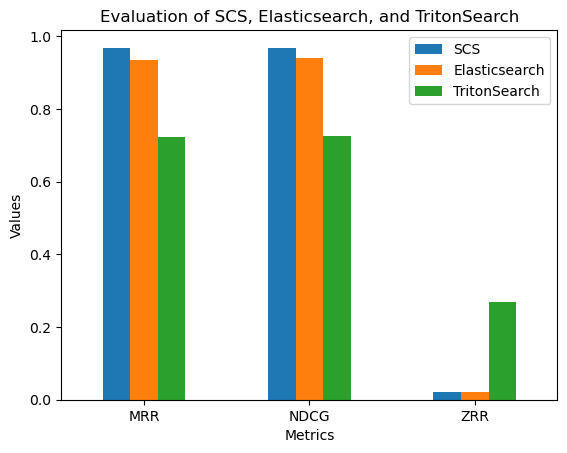

In [61]:
ax = data.T.plot.bar(rot=0)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation of SCS, Elasticsearch, and TritonSearch')
plt.show()